# Exploration of geographically weighted random forest classification modelling

To-do:
- [x] global model
- [x] model evaluation
- [x] bandwidth optimisation
- [x] feature importances
- [x] golden section bandwidth selection
- [x] other metrics than accuracy
- [x] generic support (logistic regression, gradient boosting)
- [x] dedicated classes
- [ ] local performance of models that do not support OOB
    - [x] with logistic regression I guess we can do predict_proba and measure those on the full sample directly
    - with gradient boosting we can't as the model has seen the data - might need to split to train/test to mimic OOB.
- [x] logistic regression local coefficients
- [x] (optionally) predict method

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from geodatasets import get_path
from sklearn import metrics, preprocessing

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression
from gwlearn.search import BandwidthSearch
from gwlearn.undersample import BinaryRandomUnderSampler

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

In [3]:
gdf.shape

(3085, 70)

In [4]:
# It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

In [5]:
y = gdf["FH90"] > gdf["FH90"].median()

In [6]:
X = gdf.iloc[:, 9:15]

In [8]:
%debug

> /Users/martin/dev/pysal/gwlearn/gwlearn/undersample.py(63)fit_resample()
     61             rng = np.random.default_rng(self.random_state)
     62         perm = rng.permutation(len(maj_idx))
---> 63         selected_maj_idx = maj_idx[perm[:target_maj]]
     64 
     65         keep_idx = np.concatenate([min_idx, selected_maj_idx])

*** NameError: name 'taget_maj' is not defined
np.float64(1542.0)
(1543,)
(1543,)
*** TypeError: slice indices must be integers or None or have an __index__ method
array([   0,    1,    2, ..., 3082, 3083, 3084], shape=(1543,))


### Random forest

In [6]:
gwrf = GWRandomForestClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwrf.fit(
    gdf.iloc[:, 9:15],
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


Focal metrics

In [8]:
# if your prediction rate is not 1.0, you need to mask out NAs
nan_mask = gwrf.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwrf.pred_[nan_mask])

0.7675324675324675

Pooled metrics

In [9]:
metrics.accuracy_score(gwrf.oob_y_pooled_, gwrf.oob_pred_pooled_)

0.7643688311688311

Local metrics

In [10]:
local_accuracy = gwrf.local_metric(metrics.accuracy_score)

<Axes: >

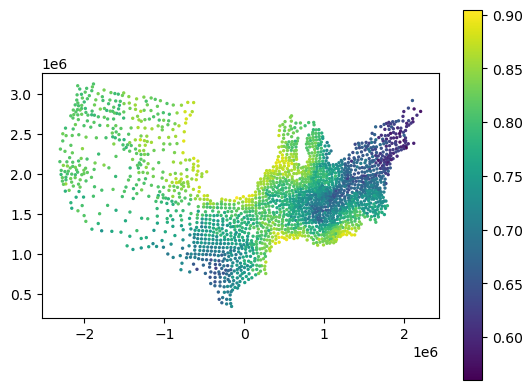

In [11]:
gdf.plot(local_accuracy, legend=True, s=2)

<Axes: >

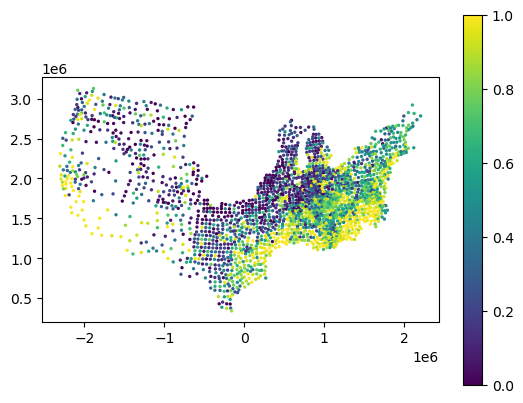

In [12]:
gdf.plot(gwrf.proba_[True], legend=True, s=2)

<Axes: >

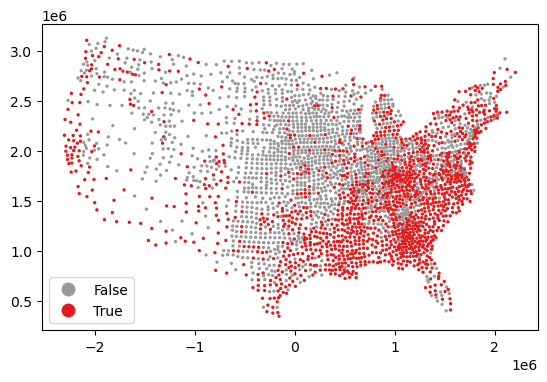

In [13]:
gdf.plot(y, legend=True, s=2, cmap="Set1_r")

OOB score (accuracy) of the global model.

In [15]:
gwrf.global_model.oob_score_

0.7854132901134522

Get local feature importances.

In [16]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.141143,0.147787,0.126227,0.160575,0.177147,0.247120
2,0.167619,0.127491,0.128013,0.169987,0.192951,0.213938
3,0.143582,0.158638,0.125196,0.159700,0.175542,0.237341
4,0.139079,0.133460,0.126718,0.169334,0.196859,0.234550
...,...,...,...,...,...,...
3080,0.139262,0.107865,0.220152,0.083062,0.292185,0.157474
3081,0.141361,0.106563,0.163277,0.203246,0.218746,0.166808
3082,0.134782,0.195495,0.191886,0.249266,0.093782,0.134790
3083,0.171965,0.160794,0.186460,0.246723,0.100752,0.133306


<Axes: >

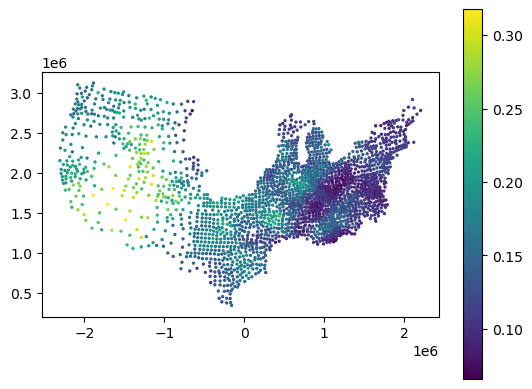

In [17]:
gdf.plot(gwrf.feature_importances_["HC60"], legend=True, s=2)

Compare to global feature importance.

In [18]:
gwrf.global_model.feature_importances_

array([0.13946965, 0.14225581, 0.16861364, 0.19817424, 0.15992872,
       0.19155794])

### Gradient boosting

In [19]:
gwgb = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwgb.fit(
    gdf.iloc[:, 9:15],
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


Global score (accuracy) for the GW model measured based on prediction of focals using focal model only.

In [20]:
# if your prediction rate is not 1.0, you need to mask out NAs
nan_mask = gwgb.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwgb.pred_[nan_mask])

0.7528138528138528

Get local feature importances.

In [21]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.178138,0.128188,0.061755,0.156530,0.153272,0.322117
2,0.189922,0.126111,0.063131,0.158854,0.124213,0.337768
3,0.154293,0.133378,0.073180,0.177225,0.069446,0.392477
4,0.177972,0.127630,0.076130,0.151980,0.112866,0.353422
...,...,...,...,...,...,...
3080,0.106021,0.049750,0.146465,0.051568,0.581501,0.064695
3081,0.090319,0.065899,0.141990,0.212114,0.453734,0.035943
3082,0.108462,0.194254,0.192112,0.308932,0.068496,0.127744
3083,0.143431,0.145732,0.155867,0.384614,0.053131,0.117224


<Axes: >

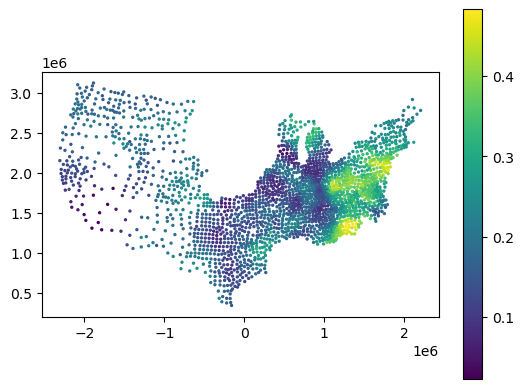

In [22]:
gdf.plot(gwgb.feature_importances_["HR90"], legend=True, s=2)

Compare to global feature importance.

In [23]:
gwgb.global_model.feature_importances_

array([0.05254643, 0.06184926, 0.12294406, 0.15103383, 0.22404795,
       0.38757847])

### Logistic regression

In [24]:
gwlr = GWLogisticRegression(
    geometry=gdf.geometry,
    bandwidth=900_000,
    fixed=True,
    n_jobs=-1,
    keep_models=True,
    max_iter=500,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
)

/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,bandwidth,900000
,fixed,True
,kernel,'bisquare'
,include_focal,True
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None


Focal metrics

In [25]:
# if your prediction rate is not 1.0, you need to mask out NAs
nan_mask = gwlr.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwlr.pred_[nan_mask])

0.7991746905089409

Pooled metrics

In [26]:
metrics.accuracy_score(gwlr.y_pooled_, gwlr.pred_pooled_)

0.7869420636659645

Local metrics

In [27]:
local_accuracy = gwlr.local_metric(metrics.accuracy_score)

<Axes: >

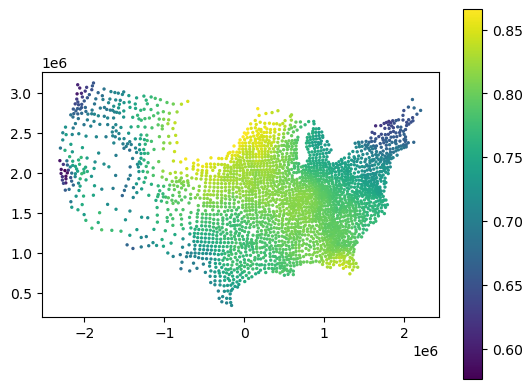

In [28]:
gdf.plot(local_accuracy, legend=True, s=2)

Local coefficients

In [29]:
gwlr.local_coef_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.309215,0.164623,0.037579,0.258089,1.440022,0.918536
2,0.315430,0.165743,0.053384,0.259558,1.454450,0.904669
3,0.314561,0.166154,0.014911,0.260348,1.376091,0.914176
4,0.322282,0.168002,0.066870,0.261307,1.454912,0.884666
...,...,...,...,...,...,...
3080,0.066790,0.452212,0.537811,-0.062854,1.140241,0.753478
3081,0.112027,0.112244,0.584092,0.352214,1.577165,0.871271
3082,-0.105918,0.494388,0.321603,0.658542,1.832182,1.244258
3083,-0.168077,0.487770,0.378523,0.613317,2.114276,1.437605


<Axes: >

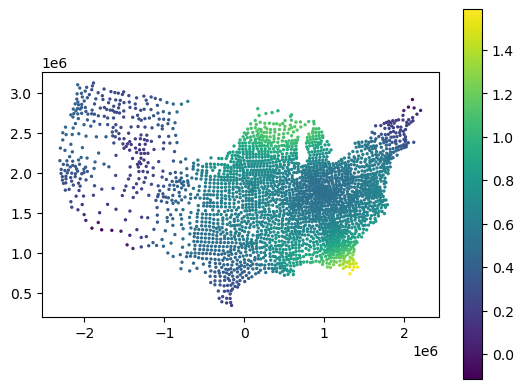

In [30]:
gdf.plot(gwlr.local_coef_["HR90"], legend=True, s=2)

Local intercepts

<Axes: >

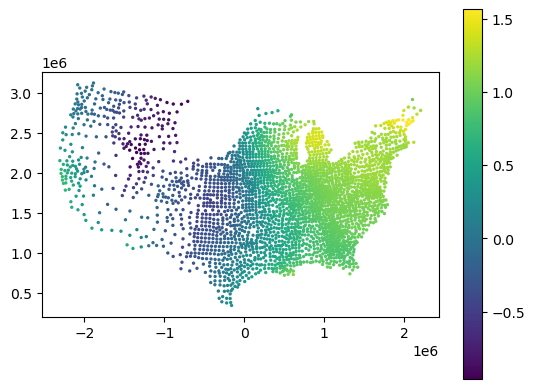

In [31]:
gdf.plot(gwlr.local_intercept_, s=2, legend=True)

## Bandwidth search

Golden section search with a fixed distance bandwidth.

In [32]:
search = BandwidthSearch(
    GWLogisticRegression,
    geometry=gdf.geometry,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aic",
    max_iterations=3,
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
    max_iter=500,
)
search.fit(
    gdf.iloc[:, 9:15],
    y,
)

Bandwidth: 918447.5, score: 2364.143
Bandwidth: 1331552.5, score: 2509.350
Bandwidth: 663120.61, score: 2309.652
Bandwidth: 505326.89, score: 2254.043
Bandwidth: 407799.68, score: 2215.765
Bandwidth: 347527.21, score: 2220.596
Bandwidth: 445052.15, score: 2229.852
Bandwidth: 384778.81, score: 2207.962
Bandwidth: 370549.49, score: 2221.485
Bandwidth: 393571.22, score: 2212.380
Bandwidth: 379343.1, score: 2206.565
Bandwidth: 375984.66, score: 2216.272
Bandwidth: 381419.71, score: 2217.420
Bandwidth: 378060.69, score: 2211.450
Bandwidth: 380136.66, score: 2217.962
Bandwidth: 378853.65, score: 2207.187
Bandwidth: 379646.59, score: 2217.124
Bandwidth: 379156.53, score: 2207.130
Bandwidth: 379459.4, score: 2213.089
Bandwidth: 379272.22, score: 2206.607
Bandwidth: 379387.9, score: 2213.132
Bandwidth: 379316.41, score: 2206.588
Bandwidth: 379360.59, score: 2213.144
Bandwidth: 379333.28, score: 2206.572


Get the optimal one.

In [33]:
search.scores_

9.184475e+05    2364.142974
1.331552e+06    2509.349738
6.631206e+05    2309.651536
5.053269e+05    2254.042931
4.077997e+05    2215.764565
3.475272e+05    2220.595820
4.450521e+05    2229.851559
3.847788e+05    2207.961793
3.705495e+05    2221.485339
3.935712e+05    2212.379600
3.793431e+05    2206.564757
3.759847e+05    2216.272263
3.814197e+05    2217.419825
3.780607e+05    2211.450048
3.801367e+05    2217.961819
3.788536e+05    2207.186929
3.796466e+05    2217.124299
3.791565e+05    2207.129844
3.794594e+05    2213.088606
3.792722e+05    2206.606987
3.793879e+05    2213.132099
3.793164e+05    2206.588128
3.793606e+05    2213.144032
3.793333e+05    2206.572411
dtype: float64

Golden section search with an adaptive KNN bandwidth.

In [34]:
search = BandwidthSearch(
    GWLogisticRegression,
    geometry=gdf.geometry,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    metrics=["log_loss"],
    interval=100,
    criterion="aicc",
    verbose=True,
    max_iter=500,  # passed to log regr
)
search.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    y,
)

Bandwidth: 50.00, aicc: 3496.602
Bandwidth: 150.00, aicc: 2590.608
Bandwidth: 250.00, aicc: 2470.417
Bandwidth: 350.00, aicc: 2467.736
Bandwidth: 450.00, aicc: 2507.082
Bandwidth: 550.00, aicc: 2522.316
Bandwidth: 650.00, aicc: 2543.729
Bandwidth: 750.00, aicc: 2612.469
Bandwidth: 850.00, aicc: 2655.850
Bandwidth: 950.00, aicc: 2712.442


<Axes: >

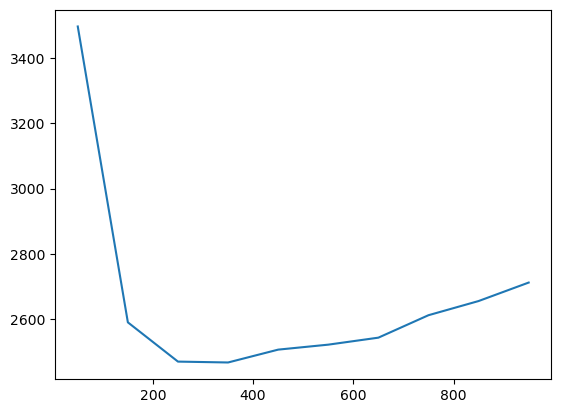

In [35]:
search.scores_.plot()

Get the optimal one.

In [36]:
search.optimal_bandwidth_

np.int64(350)

<Axes: >

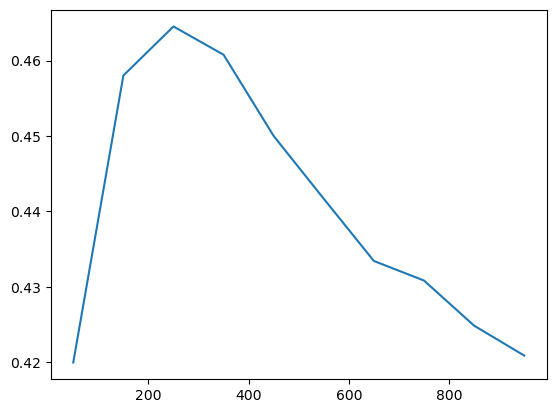

In [37]:
search.metrics_['log_loss'].plot()

## Prediction

If you want to use the model for prediction, all the local models need to be retained. That may require significant memory for RF.

In [38]:
gwlr = GWLogisticRegression(
    geometry=gdf.geometry,
    bandwidth=918447,
    fixed=True,
    n_jobs=-1,
    verbose=True,
    max_iter=500,  # passed to log regr
    keep_models=True,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
)

0.00s: Building weights
2.70s: Weights ready
2.70s: Fitting the models
11.55s: Models fitted
11.68s: Fitting global model
11.69s: Computing global likelihood
11.69s: Computing information criteria


/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,bandwidth,918447
,fixed,True
,kernel,'bisquare'
,include_focal,True
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None


In [39]:
all_data = pd.DataFrame(
    preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
)

Predict probabilities

In [40]:
pp = gwlr.predict_proba(all_data.iloc[:10], geometry=gdf.geometry.iloc[:10])
pp

,False,True
0,0.820463,0.179537
1,0.622481,0.377519
2,0.692990,0.307010
3,0.650928,0.349072
4,0.718960,0.281040
5,0.759063,0.240937
6,0.642475,0.357525
7,0.773220,0.226780
8,0.533983,0.466017
9,0.785572,0.214428


Predict label (taking max of probabilities)

In [ ]:
gwlr.predict(all_data.iloc[5:10], geometry=gdf.geometry.iloc[5:10])

5    False
6    False
7    False
8    False
9    False
dtype: bool

Exception ignored in: <function ResourceTracker.__del__ at 0x1055793a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1026813a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/m